# **Multi-Mapping Reads: Effectiveness**
### ***E. coli + Bacillus subtilis (Seed=128, 256, 512)***
* **Effectiveness of this approach to detect bowtie alignment errors.**
* **MLP inference only on the bowtie-selected alignments. (Recall score)**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import recall_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model
import os

plt.rcParams['font.family'] = 'serif'            # Use a specific font
plt.rcParams['font.size'] = 14                   # Set a general font size

2025-10-03 20:02:23.946115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759521744.171611      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759521744.237776      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Utility function: keep k=? columns
def slice_x(x, k_to_keep=9):
    cols_to_keep = [f for f in x.columns.values if f not in ['bowtie',] and not f.startswith('tfidf_k')]
    cols_to_keep.extend([f for f in x.columns.values if f.startswith(f'tfidf_k{k_to_keep}_')])
    x_sliced = x[cols_to_keep].copy()
    return x_sliced

# Utility function: evaluate model detection counts
def eval_incorrect(m, X, y, k=9, threshold=0.5):
    """
    Returns recall for class 0 ('Incorrect') using sklearn.recall_score.
    Also returns a confusion matrix.
    """
    y = np.asarray(y).ravel().astype(int)

    # Get hard predictions (1='Correct', 0='Incorrect')
    if hasattr(m, "predict_proba"):            # sklearn
        p1 = m.predict_proba(X)[:, 1]          # P(class=1)
        y_pred = (p1 >= threshold).astype(int)
    elif hasattr(m, "decision_function"):      # sklearn (score; threshold at 0)
        s = m.decision_function(X)
        y_pred = (s >= 0).astype(int)
    else:                                      # Keras/TF sigmoid
        p1 = np.asarray(m.predict(X, verbose=0)).ravel()
        y_pred = (p1 >= threshold).astype(int)

    # Recall for class 0
    rec0 = recall_score(y, y_pred, pos_label=0)
    cm = confusion_matrix(y, y_pred, labels=[0, 1])
    return rec0, cm


In [3]:
def prepare_report(x, y, data_dir, best_model_path, k, title=''):
    print('========================================')
    print(f'[{title}]: k={k}')
    print('========================================')
    
    # We only keep alns which were selected by bowtie, since in real life scenario, we want to avoid wrong alignments by bowtie
    # Joining features and labels
    xy = pd.concat(
        [x.reset_index(drop=True), y.reset_index(drop=True)], 
        axis=1
    )
    
    # Filtering rows (keeping only bowtie-selected)
    xy = xy[xy['bowtie']==1.0]
    print(f"Bowtie selected alignments={len(xy)}, errors={len(xy[xy['label']==0])}")
    
    # Splitting again
    _c = x.shape[1]
    x_bt = xy.iloc[:, :_c]              # first c columns (features)
    y_bt = xy.iloc[:, _c:].iloc[:, 0]   # remaining columns (label)
    
    # Filtering k=best features (columns)
    x_bt = slice_x(x_bt, k_to_keep=k)
    
    # Load best saved model
    best_model = load_model(best_model_path)
    print(f'loaded: {best_model_path}\n')

    # Evaluate counts
    recall, cm = eval_incorrect(m=best_model, X=x_bt, y=y_bt, k=k)
    print(f"Recall ({title}): {recall:.6f}\n")

    # Plot confusionmatrix
    disp = ConfusionMatrixDisplay(cm, display_labels=["Incorrect", "Correct"])
    disp.plot(cmap="Blues", values_format="d")
    plt.tight_layout()
    plt.show()


# E. coli

[E.coli s128]: k=10
Bowtie selected alignments=3022, errors=147


2025-10-03 20:02:51.320108: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


loaded: /kaggle/input/mmr-train-mlp-ecoli-s128/model_ecoli_s128_k10_20251003_125656.keras

Recall (E.coli s128): 0.489796



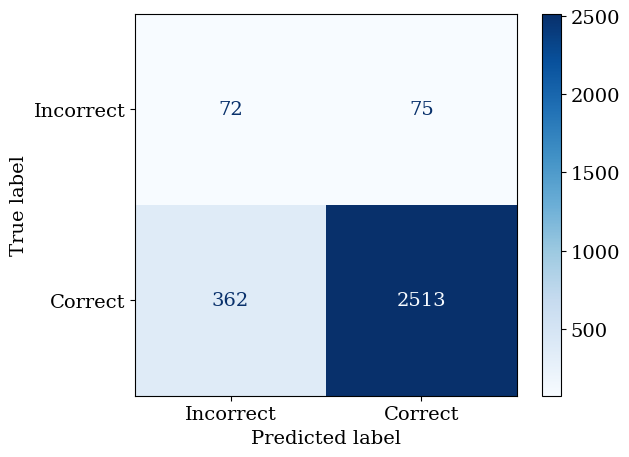

In [4]:
# E.coli (seed=128)

data_dir = '/kaggle/input/mmr-dataprep-ecoli/ecoli/data/seed128/'
best_model_path = '/kaggle/input/mmr-train-mlp-ecoli-s128/model_ecoli_s128_k10_20251003_125656.keras'
k = 10
X = pd.read_csv(os.path.join(data_dir, 'x_test.csv'))
y = pd.read_csv(os.path.join(data_dir, 'y_test.csv')).iloc[:, 0]

prepare_report(X, y, data_dir, best_model_path, k, title='E.coli s128')

[E.coli s256]: k=9
Bowtie selected alignments=3052, errors=155
loaded: /kaggle/input/mmr-train-mlp-ecoli-s256/model_ecoli_s256_k9_20251003_123408.keras

Recall (E.coli s256): 0.535484



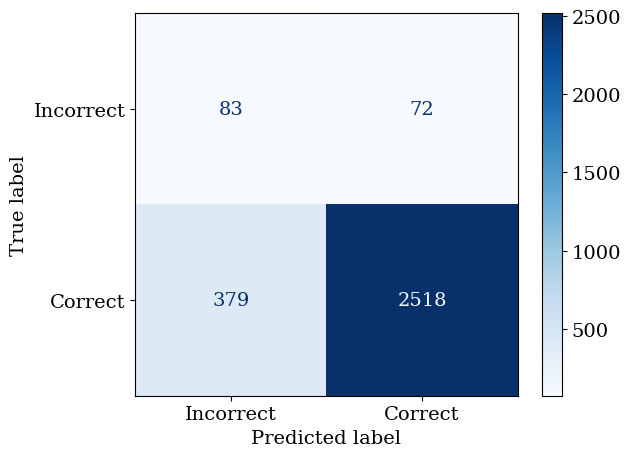

In [5]:
# E.coli (seed=256)

data_dir = '/kaggle/input/mmr-dataprep-ecoli/ecoli/data/seed256/'
best_model_path = '/kaggle/input/mmr-train-mlp-ecoli-s256/model_ecoli_s256_k9_20251003_123408.keras'
k = 9
X = pd.read_csv(os.path.join(data_dir, 'x_test.csv'))
y = pd.read_csv(os.path.join(data_dir, 'y_test.csv')).iloc[:, 0]

prepare_report(X, y, data_dir, best_model_path, k, title='E.coli s256')

[E.coli s512]: k=9
Bowtie selected alignments=2968, errors=133
loaded: /kaggle/input/mmr-train-mlp-ecoli-s512/model_ecoli_s512_k9_20251003_163426.keras

Recall (E.coli s512): 0.436090



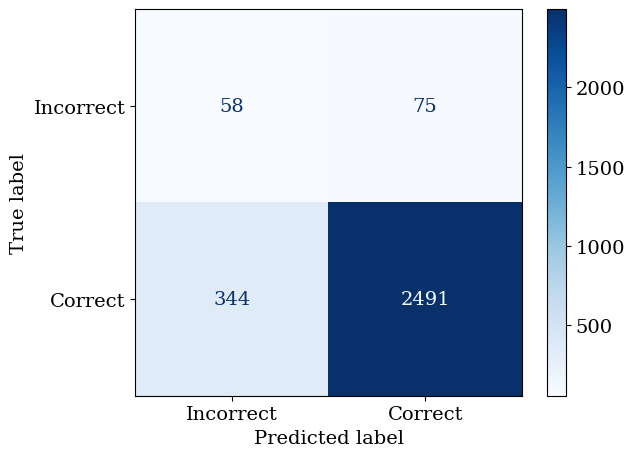

In [6]:
# E.coli (seed=512)

data_dir = '/kaggle/input/mmr-dataprep-ecoli/ecoli/data/seed512/'
best_model_path = '/kaggle/input/mmr-train-mlp-ecoli-s512/model_ecoli_s512_k9_20251003_163426.keras'
k = 9
X = pd.read_csv(os.path.join(data_dir, 'x_test.csv'))
y = pd.read_csv(os.path.join(data_dir, 'y_test.csv')).iloc[:, 0]

prepare_report(X, y, data_dir, best_model_path, k, title='E.coli s512')

# Bacillus subtillis

[Bacillus s128]: k=10
Bowtie selected alignments=1927, errors=152
loaded: /kaggle/input/mmr-train-mlp-bacillus-s128/model_bacillus_s128_k10_20251003_170259.keras

Recall (Bacillus s128): 0.631579



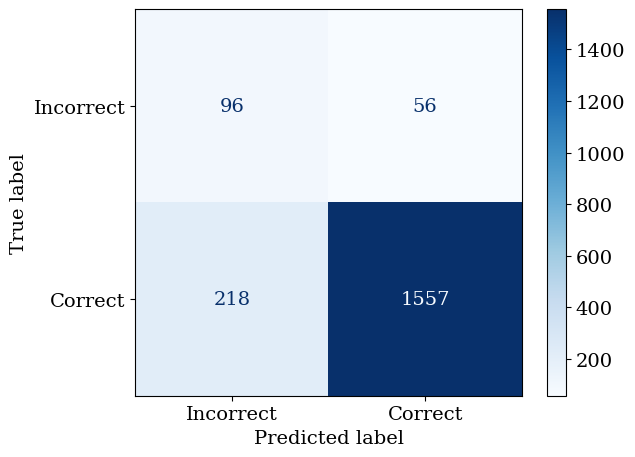

In [7]:
# Bacillus subtillis (seed=128)

data_dir = '/kaggle/input/mmr-dataprep-bacillus/bacillus/data/seed128/'
best_model_path = '/kaggle/input/mmr-train-mlp-bacillus-s128/model_bacillus_s128_k10_20251003_170259.keras'
k = 10
X = pd.read_csv(os.path.join(data_dir, 'x_test.csv'))
y = pd.read_csv(os.path.join(data_dir, 'y_test.csv')).iloc[:, 0]

prepare_report(X, y, data_dir, best_model_path, k, title='Bacillus s128')

[Bacillus s256]: k=10
Bowtie selected alignments=1900, errors=162
loaded: /kaggle/input/mmr-train-mlp-bacillus-s256/model_bacillus_s256_k10_20251003_170856.keras

Recall (Bacillus s256): 0.648148



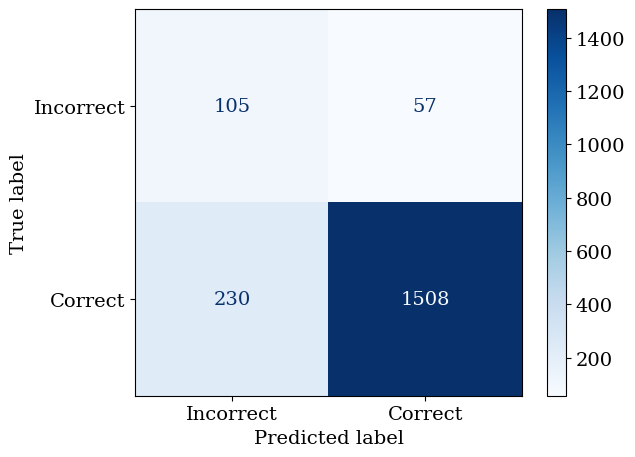

In [8]:
# Bacillus subtillis (seed=256)

data_dir = '/kaggle/input/mmr-dataprep-bacillus/bacillus/data/seed256/'
best_model_path = '/kaggle/input/mmr-train-mlp-bacillus-s256/model_bacillus_s256_k10_20251003_170856.keras'
k = 10
X = pd.read_csv(os.path.join(data_dir, 'x_test.csv'))
y = pd.read_csv(os.path.join(data_dir, 'y_test.csv')).iloc[:, 0]

prepare_report(X, y, data_dir, best_model_path, k, title='Bacillus s256')

[Bacillus s256]: k=10
Bowtie selected alignments=1967, errors=187
loaded: /kaggle/input/mmr-train-mlp-bacillus-s512/model_bacillus_s512_k10_20251003_172950.keras

Recall (Bacillus s256): 0.641711



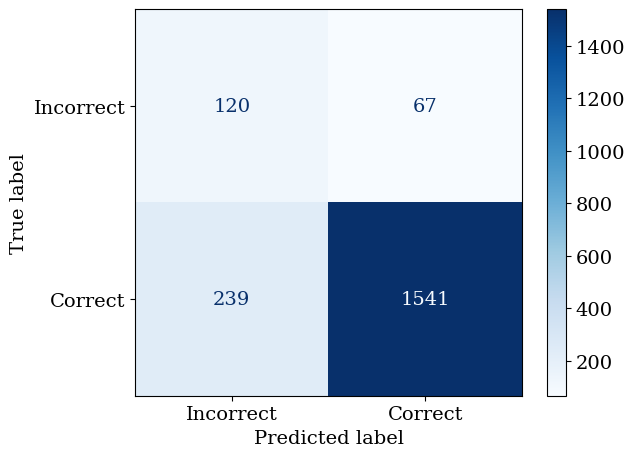

In [9]:
# Bacillus subtillis (seed=512)

data_dir = '/kaggle/input/mmr-dataprep-bacillus/bacillus/data/seed512/'
best_model_path = '/kaggle/input/mmr-train-mlp-bacillus-s512/model_bacillus_s512_k10_20251003_172950.keras'
k = 10
X = pd.read_csv(os.path.join(data_dir, 'x_test.csv'))
y = pd.read_csv(os.path.join(data_dir, 'y_test.csv')).iloc[:, 0]

prepare_report(X, y, data_dir, best_model_path, k, title='Bacillus s256')